# <font color = 'indianred'>**Emotion Detection - MultiLabel** </font>

**Plan**

1. Set Environment
2. Load Dataset
3. Load Pre-trained Tokenizer
4. Train Model
     1. Compute Metric Function <br>
     2. Training Arguments <br>
     3. Specify Model
     4. Instantiate Trainer <br>
     5. Setup WandB <br>
     6. Training and Validation

   






















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [ ]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  !pip install transformers evaluate wandb datasets accelerate -U -qq
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannoor/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<font color = 'indianred'> *Load Libraries* </font>

In [ ]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np


# New libraries introduced in this notebook

from datasets import load_dataset
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig

import wandb
import evaluate




# <font color = 'indianred'> **2. Load_Dataset** </font>

In [ ]:
emotion_data = load_dataset('harpreetmann/train_emotion_spring_2024')


In [ ]:
emotion_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1545
    })
})

In [ ]:
emotion_data['train'][0:2]

{'text': ['Does anyone know, are both Sims in a dual sim phone both locked to the same network! #worry',
  'A not very young man compiled info on a smiling baby then a mattress created new evil.'],
 'label': [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
  [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}

In [ ]:
labels = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

# <font color = 'indianred'>**3. Load pre-trained Tokenizer**</font>



In [ ]:
# flan t5 base
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

<font color = 'indianred'> *Use map function to apply tokenization to all splits*

In [ ]:
tokenized_dataset= emotion_data.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
# tokenized_dataset.set_format(type='torch')

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1545
    })
})

#  <font color = 'indianred'> **4. Model Training**

##  <font color = 'indianred'> **4.1 compute_metrics function** </font>



In [ ]:
accuracy_metric = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # print(logits.shape)
    preds = (logits > 0).astype(int)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy':accuracy['accuracy'],
            }

## <font color = 'indianred'> **4.2 Training Arguments**</font>







In [ ]:
# Define the directory where model checkpoints will be saved
run_name = "emotions_distilbert"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=10,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    # auto_find_batch_size=True,
    weight_decay=0.1,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-4,  # Step size for the optimizer during training
    lr_scheduler_type='linear',
    warmup_steps=50,  # Number of warmup steps for the learning rate scheduler
    optim='adamw_torch_fused',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    fp16=True,


)


## <font color = 'indianred'> **4.3 Specify Model**</font>

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=11, problem_type="multi_label_classification" )

config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(labels)}
label2id = {label_: id_ for id_, label_ in enumerate(labels)}
config.id2label = id2label
config.label2id = label2id
model.config = config
# model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##  <font color = 'indianred'> **4.4 Initialize Trainer**</font>



In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
   )

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


## <font color = 'indianred'> **4.5. Setup WandB**</font>

In [ ]:
wandb.login()
%env WANDB_PROJECT = emotions_kaggle_S2024

env: WANDB_PROJECT=emotions_kaggle_S2024


## <font color = 'indianred'> **4.6. Start Training**</font>

In [ ]:
trainer.train()  # start training

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,0.643900,0.535719,0.000000,0.000000,0.031068
40,0.494100,0.469057,0.000000,0.000000,0.031068
60,0.437000,0.388954,0.538796,0.253922,0.199353
80,0.373600,0.351841,0.591689,0.316373,0.214887
100,0.341800,0.327256,0.643612,0.409719,0.241424
120,0.295600,0.325397,0.650569,0.438809,0.252427
140,0.284700,0.315775,0.654923,0.463768,0.254369
160,0.269200,0.307325,0.668710,0.491509,0.259547
180,0.238700,0.314851,0.675789,0.516665,0.267961
200,0.245200,0.304900,0.671440,0.490008,0.269903


TrainOutput(global_step=490, training_loss=0.23860149821456597, metrics={'train_runtime': 112.4215, 'train_samples_per_second': 549.628, 'train_steps_per_second': 4.359, 'total_flos': 848323854707448.0, 'train_loss': 0.23860149821456597, 'epoch': 10.0})

## <font color = 'indianred'> **4.7. Validation**</font>


In [ ]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [ ]:
eval_results

{'eval_loss': 0.3400081396102905,
 'eval_f1_micro': 0.6798407314555376,
 'eval_f1_macro': 0.5473863290762847,
 'eval_accuracy': 0.24919093851132687,
 'eval_runtime': 0.5463,
 'eval_samples_per_second': 2828.037,
 'eval_steps_per_second': 23.796,
 'epoch': 10.0}

In [ ]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"],
"eval_f1_micro": eval_results["eval_f1_micro"], "eval_f1_macro": eval_results["eval_f1_macro"]})

###  <font color = 'indianred'> **Check Confusion Matrix**</font>




In [ ]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["valid"])


In [ ]:
predictions_valid = (valid_output.predictions > 0).astype(int)
labels_valid = valid_output.label_ids.astype(int)

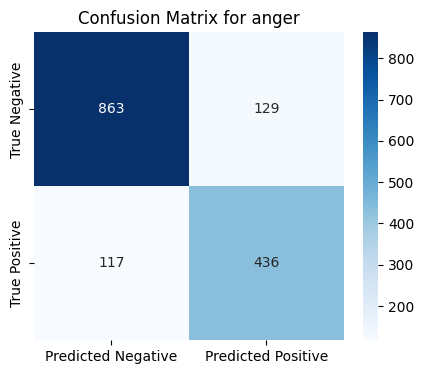

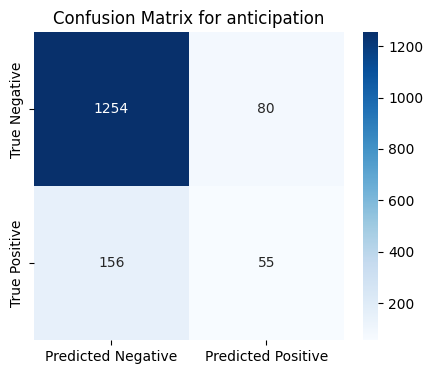

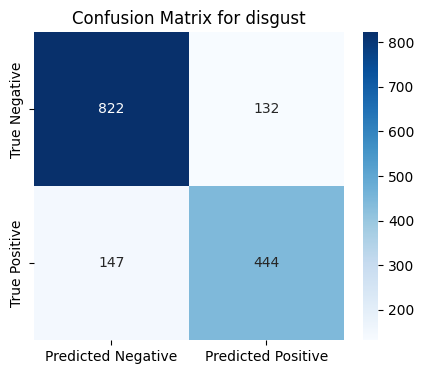

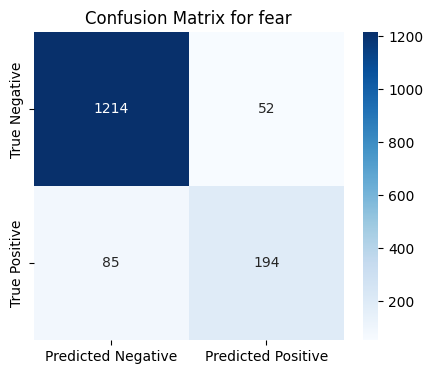

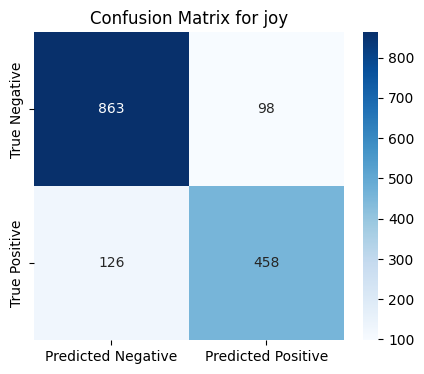

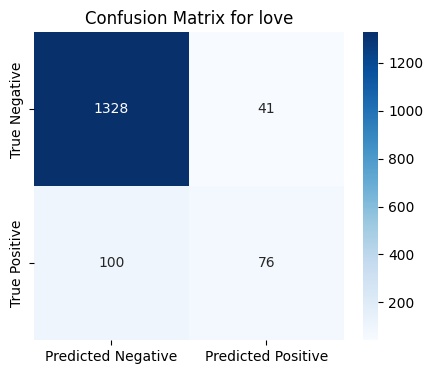

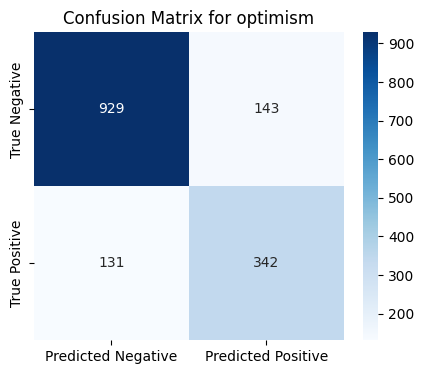

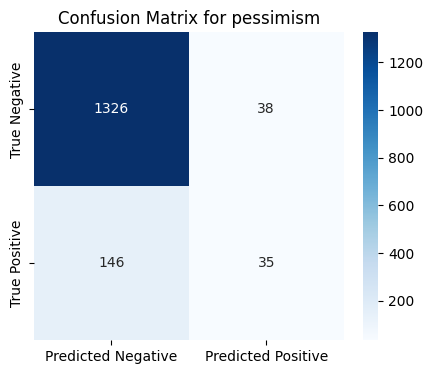

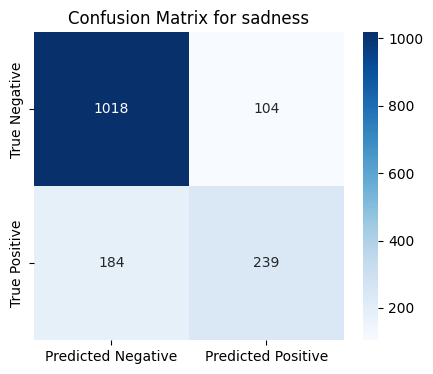

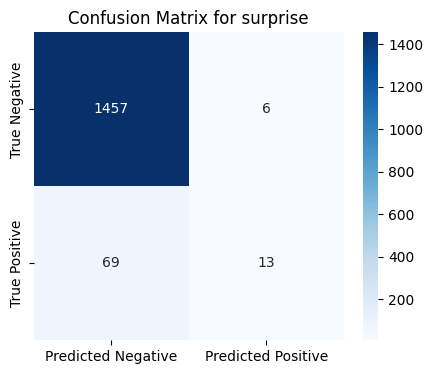

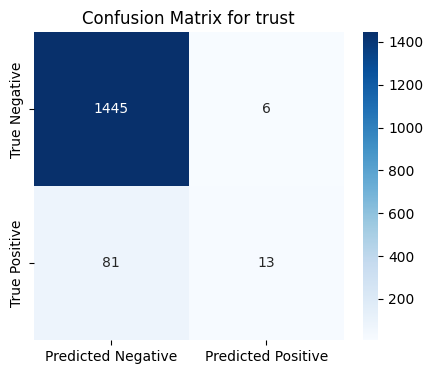

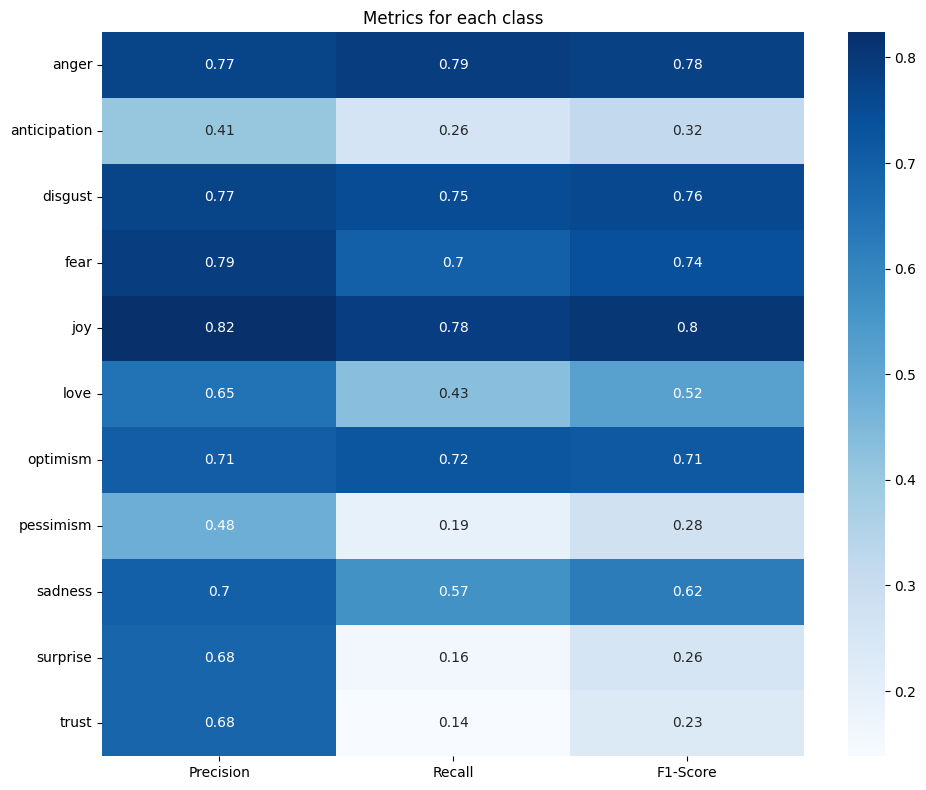

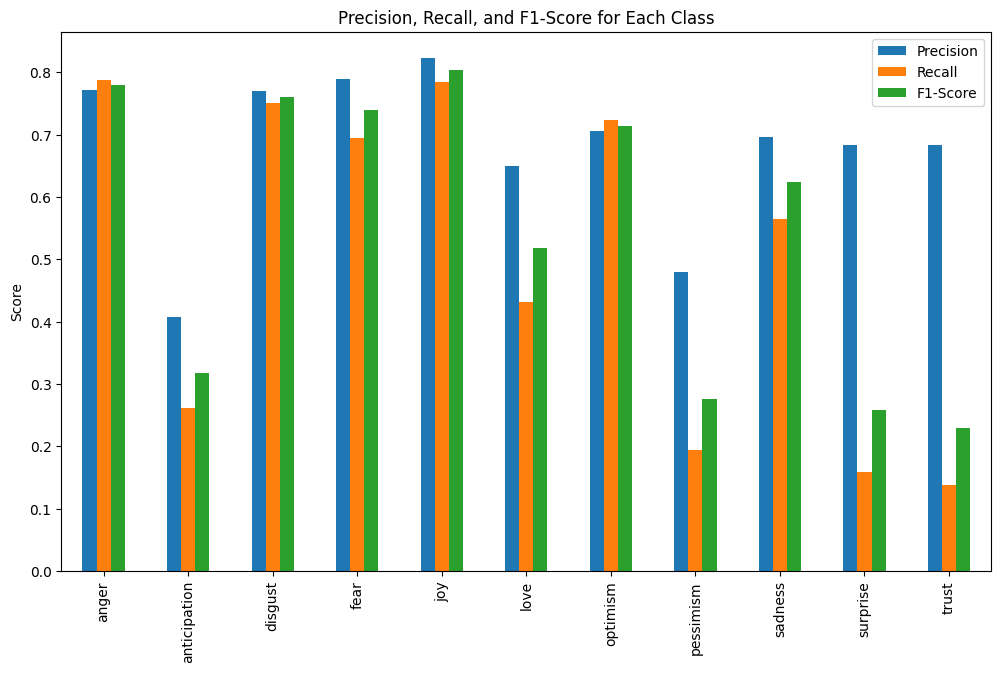

In [ ]:
# from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score

# Sample data
y_true = labels_valid
y_pred = predictions_valid
class_names = labels

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()




In [ ]:
wandb.finish()

eval/accuracy,▁▁▆▆▇▇████████▇▇▇▇▇▇▇▇▇▇▇
eval/f1_macro,▁▁▄▅▆▇▇▇█▇███████████████
eval/f1_micro,▁▁▇▇█████████████████████
eval/loss,█▆▄▂▂▂▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▂
eval/runtime,▃▆▁▄▁▆▁▁▂▁▁█▂▃▃▃▃▄▁▁▁▁▁▂▁
eval/samples_per_second,▆▃█▅█▃██▇█▇▁▇▅▆▅▆▅█████▇█
eval/steps_per_second,▆▃█▅█▃██▇█▇▁▇▅▆▅▆▅█████▇█
eval_accuracy,▁
eval_f1_macro,▁
eval_f1_micro,▁
eval_loss,▁
